In [1]:
import numpy as np
import pandas as pd
import rasterio
from scipy import stats
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from cartopy.feature import NaturalEarthFeature
import cartopy.crs as ccrs
import cartopy

In [5]:
lat = np.array([49.9166666666664 - i * 0.0416666666667 for i in range(357)])
lon = np.array([-105.0416666666507 + i * 0.0416666666667 for i in range(722)])
Lon, Lat = np.meshgrid(lon, lat)

am = rasterio.open('PRISM_tmin_stable_4kmD2_19810101_bil.bil')
a = am.read()[0, :357, 479:1201]
mask = np.where(a>-1000, 1, 0)

tmin81 = np.load('./prism/mw_tmin/1981_tmin.npz')['tmin']
t, y, x = tmin81.shape

In [9]:
Tann = np.zeros(38)
for yl in range(38):
    tmean = np.load(f'./prism/mw_tmean/{1981+yl}_tmean.npz')['tmean']
    tmean = np.where(tmean>-100, tmean, np.nan)
    Tann[yl] = np.nanmean(tmean)

In [15]:
fgreen = np.zeros((38, y, x)) * np.nan
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            df = pd.read_table(f'./GDD/output/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
            fgreen[:, i, j] = df.fgreen
            
sgs = np.nanmean(fgreen, axis=(1, 2))

In [90]:
re_Tsgs = stats.linregress(Tann, sgs)
re_Tsgs

LinregressResult(slope=-4.346955372065389, intercept=131.9495823403233, rvalue=-0.5348786327112667, pvalue=0.000540753135751528, stderr=1.1444553343329729)

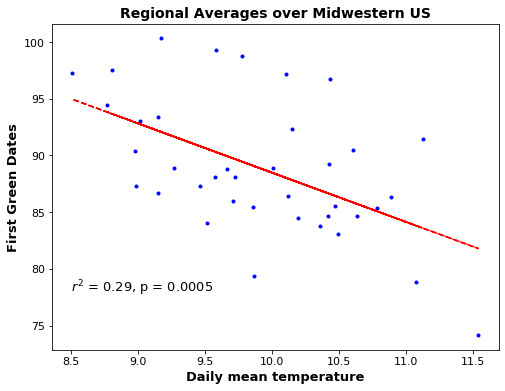

In [91]:
plt.figure(figsize=(8, 6))
plt.plot(Tann, sgs, 'bo', ms=3)
plt.plot(Tann, re_Tsgs.slope * Tann + re_Tsgs.intercept, 'r--')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('Daily mean temperature', fontsize=13, fontweight='bold')
plt.ylabel('First Green Dates', fontsize=13, fontweight='bold')
plt.title('Regional Averages over Midwestern US', fontsize=14, fontweight='bold')
plt.text(8.5, 78, f'$r^{2}$ = {re_Tsgs.rvalue**2:.2f}, p = {re_Tsgs.pvalue:.4f}', fontsize=13)
plt.savefig('./plot/freeze_index/fgreen_Tann.png')

In [66]:
lhfd = np.zeros((38, y, x)) * np.nan  # last hard freeze dates
for yl in range(38):
    tmin = np.load(f'./prism/mw_tmin/{1981+yl}_tmin.npz')['tmin']
    tmin = np.where(tmin>-100, tmin, np.nan)
    for i in range(y):
        for j in range(x):
            if mask[i, j]:
                hfd = np.where(tmin[:, i, j]<-2.2)[0] # hard freeze dates
                if len(hfd):
                    lhfd[yl, i, j] = max(np.where(hfd < 180, hfd, 0))

np.save('last_hard_freeze_dates', lhfd)

In [103]:
lhfd_ann = np.nanmean(lhfd, axis=(1,2))
re_lhfd = stats.linregress(np.delete(Tann, 30), np.delete(lhfd_ann, 30))
re_lhfd

LinregressResult(slope=-4.319220118844468, intercept=145.17545783246027, rvalue=-0.592468731768644, pvalue=0.00011184201272114666, stderr=0.9927086478516157)

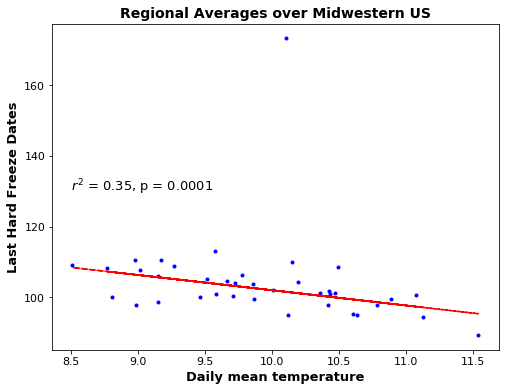

In [104]:
plt.figure(figsize=(8, 6))
plt.plot(Tann, lhfd_ann, 'bo', ms=3)
plt.plot(Tann, re_lhfd.slope * Tann + re_lhfd.intercept, 'r--')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('Daily mean temperature', fontsize=13, fontweight='bold')
plt.ylabel('Last Hard Freeze Dates', fontsize=13, fontweight='bold')
plt.title('Regional Averages over Midwestern US', fontsize=14, fontweight='bold')
plt.text(8.5, 130, f'$r^{2}$ = {re_lhfd.rvalue**2:.2f}, p = {re_lhfd.pvalue:.4f}', fontsize=13)
plt.savefig('./plot/freeze_index/LastHardFreezeDates_Tann.png')

In [ ]:
slope = np.zeros((y, x)) * np.nan 
pvalue = np.zeros((y, x)) * np.nan 
X = np.linspace(1, 38, 38)
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            r = stats.linregress(X, lhfd[:, i, j])
            slope[i, j] = r.slope
            pvalue[i, j] = r.pvalue
            
np.save('./var/LastHardFreeze_slope', slope)
np.save('./var/LastHardFreeze_pvalue', pvalue)

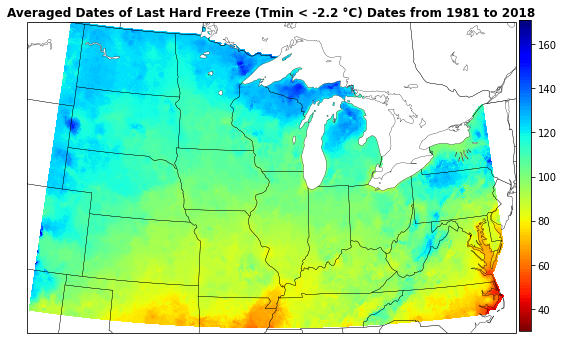

In [18]:
lhfd = np.load('last_hard_freeze_dates.npy')

fig = plt.figure(figsize=(8, 6))
extent = [-105, -75, 34, 49]
ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
ax.set_extent(extent)
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.3, edgecolor="black")
ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

levels = MaxNLocator(nbins=100).tick_values(30, 170)
cmap = plt.get_cmap('jet_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

pc = plt.pcolormesh(Lon, Lat, lhfd.mean(axis=0), cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

plt.title(f'Averaged Dates of Last Hard Freeze (Tmin < -2.2 \u00b0C) Dates from 1981 to 2018', fontsize=12, fontweight='bold')

fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=[40, 60, 80, 100, 120, 140, 160])
plt.savefig(f'./plot/freeze_index/LastHardFreeze_mean.png')

<ipython-input-17-1ba92439262d>:21: RuntimeWarning: invalid value encountered in less
  plt.scatter(Lon, Lat, np.where(pvalue<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())


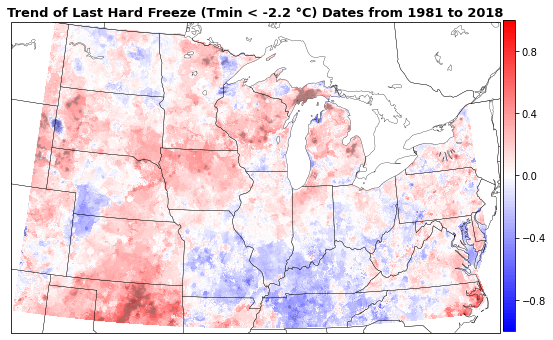

In [17]:
slope = np.load('./var/LastHardFreeze_slope.npy')
pvalue = np.load('./var/LastHardFreeze_pvalue.npy')

fig = plt.figure(figsize=(8, 6))
extent = [-105, -75, 34, 49]
ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
ax.set_extent(extent)
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.3, edgecolor="black")
ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

levels = MaxNLocator(nbins=100).tick_values(-1, 1)
cmap = plt.get_cmap('bwr')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

pc = plt.pcolormesh(Lon, Lat, slope, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
plt.scatter(Lon, Lat, np.where(pvalue<0.05, 1, np.nan), 'grey', alpha=.1, transform=ccrs.PlateCarree())

plt.title(f'Trend of Last Hard Freeze (Tmin < -2.2 \u00b0C) Dates from 1981 to 2018', fontsize=13, fontweight='bold')

fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=[-.8, -.4, 0, .4, .8])
plt.savefig(f'./plot/freeze_index/LastHardFreeze_trend.png')

In [19]:
lhfd = np.load('last_hard_freeze_dates.npy')
FSI = np.zeros((38, y, x)) * np.nan
for i in range(y):
    for j in range(x):
        if mask[i, j]:
            df = pd.read_table(f'./GDD/output/yearly/{Lat[i, j]:.2f}_{Lon[i, j]:.2f}_yearly.txt', delim_whitespace=True, 
                                   names=('year','fgreen','bloom','yeild','INJDAYS','POORDAYS'))
            FSI[:, i, j] = lhfd[:, i, j] - df.fgreen
np.save('./var/FSI', FSI)

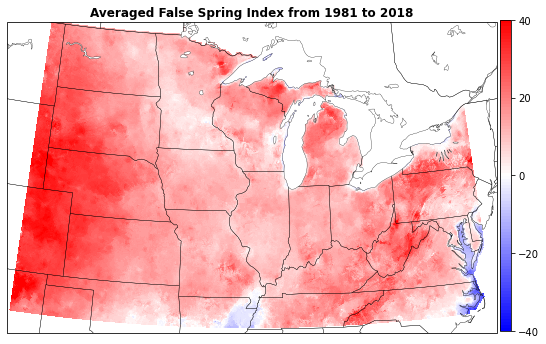

In [8]:
FSI = np.load('./var/FSI.npy')

fig = plt.figure(figsize=(8, 6))
extent = [-105, -75, 34, 49]
ax = plt.axes(projection=ccrs.AlbersEqualArea(np.mean(extent[:2]), np.mean(extent[2:])))
ax.set_extent(extent)
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.3, edgecolor="black")
ax.add_feature(cartopy.feature.BORDERS, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.COASTLINE, lw=.3, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='white', lw=.3)

levels = MaxNLocator(nbins=100).tick_values(-40 ,40)
cmap = plt.get_cmap('bwr')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

pc = plt.pcolormesh(Lon, Lat, FSI.mean(axis=0), cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

plt.title(f'Averaged False Spring Index from 1981 to 2018', fontsize=12, fontweight='bold')

fig.subplots_adjust(bottom=0, top=0.95, left=0.05, right=0.9)
cb_ax = fig.add_axes([0.905, 0.12, 0.02, 0.72])
cbar = fig.colorbar(pc, cax=cb_ax, ticks=[-40, -20, 0, 20, 40])
plt.savefig(f'./plot/freeze_index/FSI_mean.png')

In [14]:
fsi_ann = np.nanmean(FSI, axis=(1,2))
re_fsi = stats.linregress(np.delete(Tann, 30), np.delete(fsi_ann, 30))
re_fsi

LinregressResult(slope=0.12185124392658679, intercept=12.538467990620104, rvalue=0.015212066283979576, pvalue=0.928795390214783, stderr=1.3538092608074237)

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(Tann, np.nanmean(FSI, axis=(1,2)), 'bo', ms=3)
plt.plot(Tann, re_fsi.slope * Tann + re_fsi.intercept, 'r--')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('Daily mean temperature', fontsize=13, fontweight='bold')
plt.ylabel('Last Hard Freeze Dates', fontsize=13, fontweight='bold')
plt.title('Regional Averages over Midwestern US', fontsize=14, fontweight='bold')
plt.text(8.5, 60, f'$r^{2}$ = {re_fsi.rvalue**2:.4f}, p = {re_fsi.pvalue:.4f}', fontsize=13)
plt.savefig('./plot/freeze_index/FSI_Tann.png')